Parsed 8 images from the PDF file


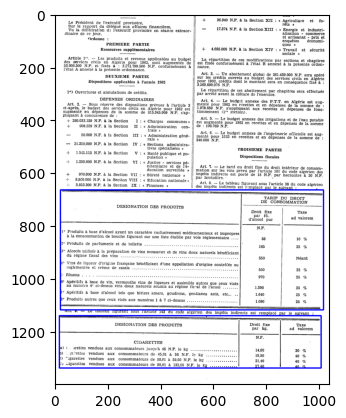

In [1]:
from table_detection import detect_table_from_image_data
from test_tables import parse_images
import numpy as np
from matplotlib import pyplot as plt
import cv2

pdf_path = "/Users/nabiltchoulak/code/ocr-recognition/data_test/F1962008.pdf"
images = parse_images(pdf_path)

for pil_page_image in images:
    page_image_rgb = np.array(pil_page_image)
    table_boxes, img_grid = detect_table_from_image_data(page_image_rgb)
    if (len(table_boxes) > 0):
        for x, y, w, h in table_boxes:
                cv2.rectangle(page_image_rgb, (x, y), (x + w, y + h), (0, 0, 255), 3)
        plt.imshow(page_image_rgb)
        plt.show()
        break
        

0 0
BBox inserted: [0, 0, 677, 1]
1 0
BBox inserted: [0, 0, 677, 1]
 Went into next horizontal line: (0, (0, 0, 994, 0))
0 0
BBox inserted: [0, 0, 677, 1]
1 0
BBox inserted: [0, 0, 677, 1]
 Went into next horizontal line: (1, (6, 1, 983, 16))
0 1
BBox inserted: [0, 1, 677, 0]
1 1
BBox inserted: [0, 1, 677, 0]
 Went into next horizontal line: (2, (587, 15, 130, 1))
0 2
BBox inserted: [0, 15, 0, 0]
 Went into next horizontal line: (3, (780, 18, 163, 2))
0 3
BBox inserted: [0, 18, 0, 0]
 Went into next horizontal line: (4, (707, 58, 271, 5))
0 4
BBox inserted: [0, 58, 0, 0]
 Went into next horizontal line: (5, (2, 120, 674, 12))
0 5
BBox inserted: [0, 120, 0, 10]
 Went into next horizontal line: (6, (687, 130, 145, 2))
0 6
BBox inserted: [0, 130, 0, 0]
 Went into next horizontal line: (7, (844, 131, 146, 2))
0 7
BBox inserted: [0, 131, 0, 0]
 Went into next horizontal line: (8, (688, 133, 144, 1))
0 8
BBox inserted: [0, 133, 0, 0]
 Went into next horizontal line: (9, (844, 134, 146, 2))
0

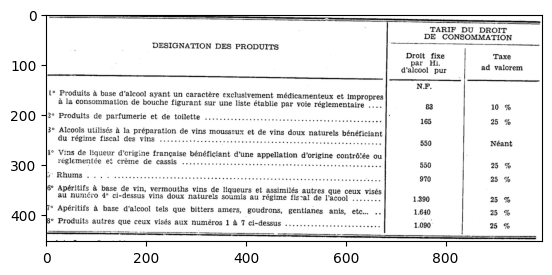

In [4]:
from table_detection import core_line_detection, find_table_bounding_boxes

"""
if (not(current_x < (horizontal_lines[v_index][0] + vertical[2]/2) < current_x + current_width) 
                and ((v_index + i) < len(horizontal_lines))):
                print(v_index + i, horizontal_lines[v_index + i][0])
                while (not(current_x < horizontal_lines[v_index + i][0] + vertical[2]/2 < current_x + current_width)):
                    i+=1
                    if ((v_index + i) >= len(horizontal_lines)):
                        i=0
                        break
"""

image = np.array(pil_page_image)
table_bbox = [x, y, w, h]

def check_line_cell_border(
    cell_origin, vertical_line_bbox, tolerance, axis_index=0
):
    # 0 axis is the X axis (horizontal axis in the array)
    if axis_index == 0:
        return abs(cell_origin[1] - vertical_line_bbox[1]) > tolerance
    # 1 axis is the Y axis (vertical axis in the array)
    if axis_index == 1:
        return abs(cell_origin[0] - vertical_line_bbox[0]) > tolerance

table_x_start = table_bbox[0]
table_y_start = table_bbox[1]
table_x_end = table_bbox[0] + table_bbox[2]
table_y_end = table_bbox[1] + table_bbox[3]
left_line = (0, 0, 0, table_bbox[3])
top_line = (0, 0, table_bbox[2], 0)
right_line = (table_x_end, 0, 0, table_bbox[3])
bottom_line = (0, table_y_end, table_bbox[2], 0)
np_img = np.array(image)
# Do the processing only inside the table
np_img_cropped = np_img[
    table_y_start:table_y_end,
    table_x_start:table_x_end,
    :,
]

combined_grid, contours_v, contours_h = core_line_detection(np_img_cropped, 3, 10)

vertical_lines = [cv2.boundingRect(cnt) for cnt in contours_v]

horizontal_lines = [cv2.boundingRect(cnt) for cnt in contours_h]

# Add all surrounding lines
vertical_lines.insert(0, left_line)
horizontal_lines.insert(0, top_line)
vertical_lines.insert(-1, right_line)
horizontal_lines.insert(-1, bottom_line)

vertical_lines.sort(key=lambda c: c[0])
horizontal_lines.sort(key=lambda c: c[1])

cells_bbox_list = []

current_y = horizontal_lines[0][1]
v_iterator = iter(enumerate(horizontal_lines))
h_index = 0
v_index = 0

while (current_x / table_x_end < 0.95) and (current_y / table_y_end < 0.95):
    print(h_index, v_index)
    #print(current_x / table_x_end, current_y / table_y_end)
    # find the next vertical line that defines this cell
    next_vertical_line_idx, next_vertical_line = next(
        (
            (index, vertical)
            for index, vertical in enumerate(vertical_lines[h_index:])
            if check_line_cell_border((current_x, current_y), vertical, 5, 0)
        ),
        ((len(vertical_lines) - 1), right_line),
    )

    next_horizontal_line_idx, next_horizontal_line = next(
        (
            (index, horizontal)
            for index, horizontal in enumerate(horizontal_lines[v_index:])
            if check_line_cell_border((current_x, current_y), horizontal, 5, 1)
        ),
        ((len(horizontal_lines) - 1), bottom_line),
    )

    current_height = next_horizontal_line[1] - current_y
    current_width = next_vertical_line[0] - current_x
    print(f"BBox inserted: {[current_x, current_y, current_width, current_height]}")
    cells_bbox_list.append([current_x, current_y, current_width, current_height])

    # Next horizontal index (for vertical lines) needs to be aligned with the current
    # cell right border
    h_index = next_vertical_line_idx % (len(vertical_lines) - 1)
    current_x = vertical_lines[0][h_index]

    if h_index == 0:
        v_index, current_horizontal = next(
            v_iterator, ((len(horizontal_lines) - 1), bottom_line)
        )
        print(f" Went into next horizontal line: {v_index, current_horizontal}")
        current_y = current_horizontal[1]

cells_bbox_list = [
    bbox
    for bbox in cells_bbox_list
    if (bbox[2] / table_bbox[2] > 0.05 and bbox[3] / table_bbox[3] > 0.05)
]
print(cells_bbox_list)
for x, y, w, h in cells_bbox_list:
    cv2.rectangle(np_img_cropped, (x, y), (x + w, y + h), (0, 0, 255), 3)
plt.imshow(np_img_cropped)
plt.show()
